In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras as keras

from pathlib import Path
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data_dir = '/kaggle/input/indian-grocery-image-dataset/Images'

### Importing the Data from Dataset

In [4]:
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.3)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size = (256,256),
    batch_size = 200,
    class_mode = 'categorical',
    subset = 'training')

validation_data = datagen.flow_from_directory(
  data_dir,
  target_size = (256,256),
  batch_size = 200,
  class_mode = 'categorical',
  subset = 'validation')

Found 16868 images belonging to 15 classes.
Found 7219 images belonging to 15 classes.


### Checking for any error Images

In [ ]:
import os

# Get the list of filenames for both training and validation datasets
train_filenames = train_data.filenames
validation_filenames = validation_data.filenames

# Loop through training dataset
print("Checking training dataset...")
for i, filename in enumerate(train_filenames):
    try:
        # Try loading the image
        img = train_data[i][0]
    except Exception as e:
        print(f"Error loading image {filename}: {e}")

# Loop through validation dataset
print("Checking validation dataset...")
for i, filename in enumerate(validation_filenames):
    try:
        # Try loading the image
        img = validation_data[i][0]
    except Exception as e:
        print(f"Error loading image {filename}: {e}")

### Displaying sample Images from train and test data gens

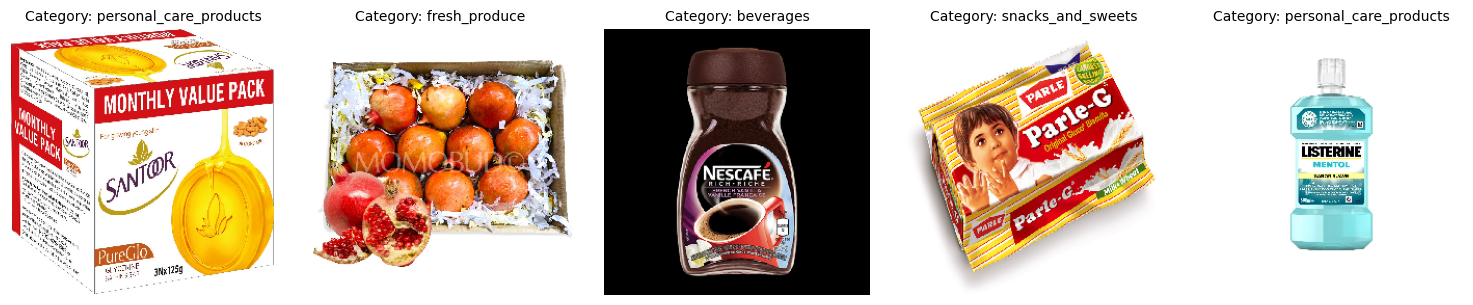

In [6]:
# Display images from training data
import os
images, labels = train_data.next()

class_names = sorted(os.listdir(data_dir))

num_images_to_display = 5

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i in range(num_images_to_display):
    axes[i].imshow(images[i])
    class_index = labels[i].argmax()
    category = class_names[class_index]
    axes[i].set_title(f'Category: {category}', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

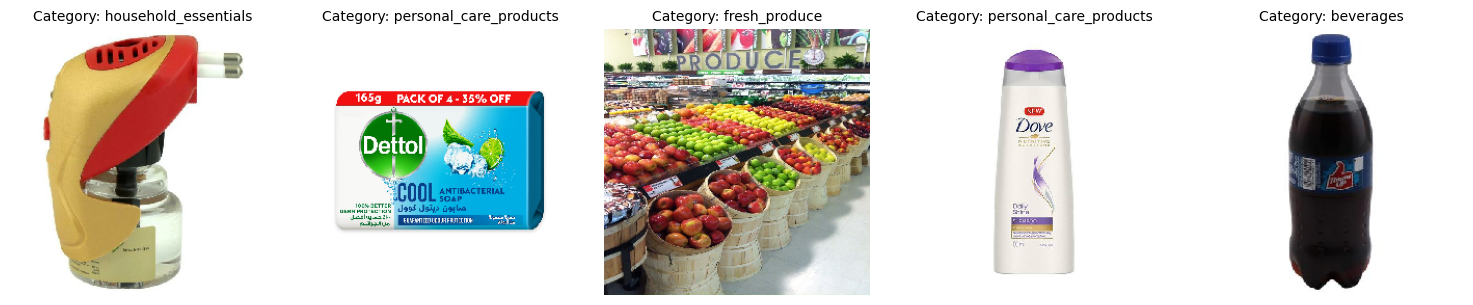

In [7]:
# Display images from validation data
images, labels = validation_data.next()

class_names = sorted(os.listdir(data_dir))

num_images_to_display = 5

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i in range(num_images_to_display):
    axes[i].imshow(images[i])
    class_index = labels[i].argmax()
    category = class_names[class_index]
    axes[i].set_title(f'Category: {category}', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Importing the Model

In [8]:
vgg19 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(125,125,3),
    pooling=max,
    classes=15,
    classifier_activation="softmax",
)

80134624/80134624 [==============================] - 0s 0us/step


### Constructing the model layers and compiling

In [9]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Add a global spatial average pooling layer
x = vgg19.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# x = Dense(512, activation='relu')(x)

# Add a dropout layer for regularization
x = Dropout(0.5)(x)

# Add a logistic layer with the number of classes you have
predictions = Dense(15, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=vgg19.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG19 layers
for layer in vgg19.layers:
    layer.trainable = False

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 125, 125, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 125, 125, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 125, 125, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 62, 62, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 62, 62, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 62, 62, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0     

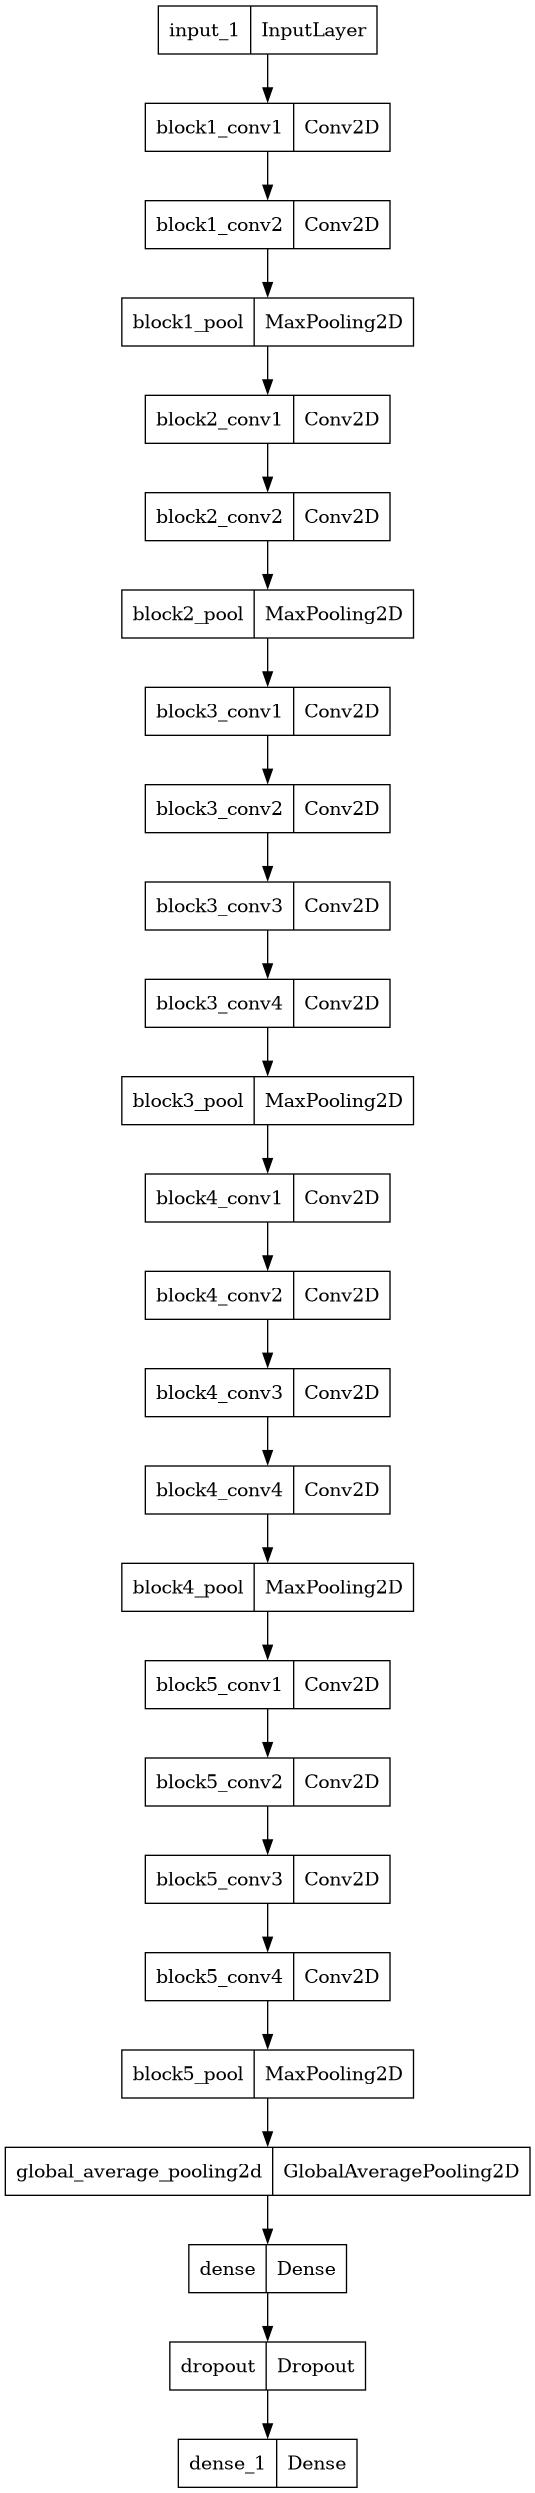

In [11]:
tf.keras.utils.plot_model(model)

### Training the Model

In [12]:
# Train the model on the new data for a few epochs
model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
I0000 00:00:1707559303.953835     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 [==============================] - 477s 5s/step - loss: 2.1258 - accuracy: 0.3227 - val_loss: 1.9534 - val_accuracy: 0.3800
Epoch 2/10
85/85 [==============================] - 315s 4s/step - loss: 1.8642 - accuracy: 0.3960 - val_loss: 1.7885 - val_accuracy: 0.4207
Epoch 3/10
85/85 [==============================] - 313s 4s/step - loss: 1.7531 - accuracy: 0.4324 - val_loss: 1.6700 - val_accuracy: 0.4582
Epoch 4/10
85/85 [==============================] - 313s 4s/step - loss: 1.6599 - accuracy: 0.4603 - val_loss: 1.6123 - val_accuracy: 0.4728
Epoch 5/10
85/85 [==============================] - 313s 4s/step - loss: 1.6106 - accuracy: 0.4775 - val_loss: 1.5313 - val_accuracy: 0.5236
Epoch 6/10
85/85 [==============================] - 313s 4s/step - loss: 1.5637 - accuracy: 0.4935 - val_loss: 1.4854 - val_accuracy: 0.5275
Epoch 7/10
85/85 [==============================] - 313s 4s/step - loss: 1.5184 - accuracy: 0.5083 - val_loss: 1.4835 - val_accuracy: 0.5257
Epoch 8/10
85/85 [======